# DEA Coastlines vector statistics <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts vector subpixel shoreline extraction for DEA Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m along Australia's non-rocky coastlines using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [`deacoastlines_statistics.py`](deacoastlines_statistics.py) Python script.

**Compatability:**
```
module use /g/data/v10/public/modules/modulefiles
module load dea/20200713
pip install --user git+https://github.com/mattijn/topojson/
```
---

In [ ]:
# !pip install --user git+https://github.com/mattijn/topojson/

### Load packages

First we import all required Python packages, and then start the vector coastline extraction process.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as deacl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## Load in data

In [ ]:
# Read in contours
# study_area = 6921
# study_area = 6511
# study_area = 6931
# study_area = 6818
# study_area = 8531
study_area = 8432
# raster_version = "coral"
# vector_version = "v0.0.1"
raster_version = 'v1.1.0'
vector_version = 'v1.1.3'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2020'


## Load DEA CoastLines rasters

In [ ]:
yearly_ds, gapfill_ds = deacl_stats.load_rasters(raster_version, 
                                                 study_area, 
                                                 water_index)
print(yearly_ds)

# Create output vector folder
output_dir = f'output_data/{study_area}_{raster_version}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

## Load vector data

In [ ]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', 
                               bbox=bbox).to_crs(yearly_ds.crs))

# Tide points
tide_points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', 
                            bbox=bbox).to_crs(yearly_ds.crs))

# Study area polygon
# studyarea_path = 'input_data/50km_albers_grid_coralislands.geojson'
studyarea_path = 'input_data/50km_albers_grid_clipped.geojson'
comp_gdf = (gpd.read_file(studyarea_path, 
                          bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = deacl_stats.load_climate_data(index='soi_local', 
                                           years=(1988, int(baseline_year)), 
                                           annual=True,
                                           detrend=True)

## Extract shoreline contours

### Extract ocean-masked contours

In [ ]:
# Generate waterbody mask
waterbody_mask = deacl_stats.waterbody_masking(
    input_data='input_data/SurfaceHydrologyPolygonsRegional.gdb',
    modification_data='input_data/estuary_mask_modifications.geojson',
    bbox=bbox,
    yearly_ds=yearly_ds)

In [ ]:
# Mask dataset to focus on coastal zone only
masked_ds = deacl_stats.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    waterbody_mask,
    tide_points_gdf,
    output_path=f'output_data/{study_area}_{raster_version}') 

In [ ]:
# Extract contours
contours_gdf = (deacl_stats.subpixel_contours(da=masked_ds,
                                              z_values=index_threshold,
                                              min_vertices=10,
                                              dim='year',
                                              output_path=f'temp.geojson')
                .set_index('year'))


## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = deacl_stats.points_on_line(contours_gdf, 
                                        baseline_year, 
                                        distance=30)

# Clip to remove rocky shoreline points
points_gdf = deacl_stats.rocky_shores_clip(points_gdf, 
                                           smartline_gdf, 
                                           buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:  

    # Calculate annual movements and residual tide heights for every 
    # contour compared to the baseline year
    points_gdf = deacl_stats.annual_movements(points_gdf,
                                              contours_gdf,
                                              yearly_ds,                                     
                                              baseline_year,
                                              water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    # Apply regression function to each row in dataset
    points_gdf = deacl_stats.calculate_regressions(points_gdf,
                                                   contours_gdf,
                                                   climate_df)

# Add count and span of valid obs, Shoreline Change Envelope (SCE), 
# Net Shoreline Movement (NSM) and Max/Min years
stats_list = ['valid_obs', 'valid_span', 'sce', 'nsm', 'max_year', 'min_year']
points_gdf[stats_list] = points_gdf.apply(
    lambda x: deacl_stats.all_time_stats(x), axis=1)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:
    
    # Set up scheme to optimise file size
    schema_dict = {key: 'float:8.2' for key in points_gdf.columns
                   if key != 'geometry'}
    schema_dict.update({'sig_time': 'float:8.3',
                        'outl_time': 'str:80',
                        'sig_soi': 'float:8.3',
                        'outl_soi': 'str:80',
                        'valid_obs': 'int:4',
                        'valid_span': 'int:4',
                        'max_year': 'int:4',
                        'min_year': 'int:4',
                       })
    col_schema = schema_dict.items()

    # Clip stats to study area extent
    stats_path = f'{output_dir}/stats_{study_area}_{vector_version}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp',
                       schema={'properties': col_schema,
                               'geometry': 'Point'})

### Export contours

In [ ]:
# Assign certainty to contours based on underlying masks
contours_gdf = deacl_stats.contour_certainty(
    contours_gdf, 
    output_path=f'output_data/{study_area}_{raster_version}')

# Add maturity details
contours_gdf['maturity'] = 'final'
contours_gdf.loc[contours_gdf.index == baseline_year, 'maturity'] = 'interim'

# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/contours_{study_area}_{vector_version}_' \
               f'{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

## Generate continental summary layer

In [ ]:
from deacoastlines_summary import main

In [ ]:
main(['out', 'v1.1.0', 'v1.1.0', '0.00', True, True, False])  # 2500 default summary
# main(['out', 'coral', 'v0.0.1', '0.00', True, True, False])  # 2500 default summary

In [ ]:
main(['out', 'v1.1.0', 'v1.1.0', '0.00', False, False, 5000]) 

In [ ]:
main(['out', 'v1.1.0', 'v1.1.0', '0.00', False, False, 2500]) 

In [ ]:
main(['out', 'v1.1.0', 'v1.1.0', '0.00', True, True, 500]) 

### Identify missed tiles

In [ ]:
# all_tiles = '2083 660 2423 3436 3437 3641 3539 3538 2374 2169 3089 2320 3640 2373 2372 2271 2270 2784 1969 2377 2379 2830 1813 676 780 678 677 2891 2890 2077 2789 2380 2278 2790 2889 1192 880 670 669 2282 984 567 559 773 774 3193 1098 1090 988 1088 1091 563 461 462 1982 1981 1880 1879 1779 1778 882 1092 1097 460 3297 3298 1089 987 565 568 778 881 985 776 675 3502 3400 661 1979 3500 1472 1575 2385 3501 3294 560 459 458 3399 3296 1301 1200 1199 2381 1405 1303 862 761 760 777 569 463 2082 1980 674 468 570 571 3091 3397 2183 2080 2582 3192 2179 2079 2078 3233 2788 4150 2626 2482 3131 3029 3132 2990 2785 467 566 464 2280 466 465 2688 1404 1302 2013 2218 2217 2115 2116 1711 2787 2687 2827 2886 2786 3031 3030 2929 2928 2319 2829 2828 2726 2523 2015 1913 1912 2421 1609 1608 1811 2625 1507 1506 4819 2588 2587 2383 2384 1298 1196 564 2181 1299 1197 1710 1297 1198 1096 764 662 865 2487 664 663 2382 562 561 1677 1676 1474 1371 1295 1296 1093 986 964 966 965 1066 1271 1270 1169 1168 5237 4107 3798 3800 4209 4208 3805 4307 4104 3799 4413 4311 4514 4003 4002 3901 3900 4207 5337 5432 3807 3705 3603 3602 5233 4308 4616 3905 4309 5134 5235 3804 3702 3701 3803 3802 5543 4511 4409 4512 5441 5339 5023 4921 5440 5437 4614 5335 5433 5436 5435 5334 5333 5331 5332 5127 4923 5330 4717 5328 5226 4310 4615 3806 5131 5029 5329 5024 5031 5133 5132 5230 5128 5232 4820 4718 4006 3904 3902 4922 4005 5231 5129 8627 8626 8625 8533 8531 8530 8529 8527 8434 8433 8432 8431 8430 8429 8428 8427 8426 8423 8422 8421 8419 8418 8335 8334 8333 8332 8331 8330 8329 8234 8233 8232 8231 8228 8227 8216 8215 8214 8211 8210 8133 8132 8131 8113 8111 8108 8107 8032 8030 8008 8007 8006 7929 7928 7906 7905 7904 7900 7832 7831 7828 7800 7799 7797 7731 7729 7727 7696 7632 7631 7630 7629 7628 7593 7592 7531 7530 7529 7490 7489 7385 7384 7285 7284 7283 7282 7276 7275 7178 7177 7176 7175 7174 7172 7061 6969 6968 6965 6958 6957 6867 6866 6863 6862 6861 6860 6857 6856 6761 6760 6759 6758 6757 6756 6754 6753 6657 6656 6557 6554 6553 6551 6550 6461 6460 6459 6458 6457 6361 6360 6357 6356 6355 6354 6260 6258 6160 6057 5956 5849 5749 5647 5646 5545 6728 6414 6923 4769 4768 4458 4560 5077 5076 5481 5792 5690 5793 5691 5478 5479 5480 4048 3946 3945 5689 5587 5586 5584 5482 5585 5483 6724 7029 6927 6932 5485 5384 5180 5179 5379 5282 5375 5381 5278 4047 4150 4355 3844 3843 4970 5693 4251 4149 3742 3741 4871 4457 4456 4354 4252 4763 5795 5376 7030 5378 5275 7135 6929 7132 5796 4971 4869 5174 5073 4766 4664 4767 4665 6828 4663 4870 7124 5794 5692 5176 4867 4765 4764 5074 4973 4972 4660 4558 7123 6309 7023 7022 7225 6717 7429 6714 7033 6925 6411 7327 6103 6612 7134 7133 7031 6818 6512 6410 6920 6921 6614 6819 6001 6000 5899 5898 6308 6307 6206 6205 6725 6620 6519 6514 6412 7229 7230 6823 6722 6518 6621 6830 6515 7026 7028 7027 6931 6721 6622 7231 6625 6413 6727 7233 7131 6623 6726 6624 6829 6517 6516 6618 6619 1473 763 2988 2481 2081 3398 8528 8532 8031 7281 4661 5279 5280 6613 6716 5277 6453 6555 6549 6755 6864 7798 8213 7930 7931 7830 7730 7024 7025 7127 7130 6930 7932 6824 6926 6715 5281 5383 5484 5380 5177 5377 5276 5175 4868 3335 2727 2728 2422 2524 2014 1812 1193 673 1372 1574 2182 2180 2486 2888 4004 4412 4513 5130 6820 7032 8112 5852 2584 5030 5228 4106 3903 3704 2989 5338 4411 4105 1067 2484 1195 2485 2586 2685 2686 2281 762 5126 5125 5227 1194 7901 8109 7129 671 672 864 8212 7903 5851 5544 5236 6651 6358 7902 7071 3090 2683 863 7232 779 2483 2583 2585 2684 2887 3295 3703 4206 4410 4559 4662 5075 5178 5229 5382 5850 5853 5952 5953 5954 5955 6158 6159 6259 6261 6353 6359 6454 6455 6456 6511 6552 6556 6652 6653 6654 6858 6865 6922 7070 7128 7173 7279 7280 7386 7387 7388 7695 8004 8005 8110 8316 8317 8318 8319 8420 8524 8525 8526'
# all_tiles = set(all_tiles.split(' '))


# # Original tiles
import glob
# vector_version = 'v1.1.0'
# all_paths = glob.glob(f'output_data/*/vectors/contours_*_{vector_version}_mndwi_0.00.geojson')
# all_tiles = set([os.path.basename(tile).split('_')[1] for tile in all_paths])


vector_version = 'v1.1.0'
processed_paths = glob.glob(f'output_data/*/vectors/contours_*_{vector_version}_mndwi_0.00.geojson')
processed_tiles = set([os.path.basename(tile).split('_')[1] for tile in processed_paths])
# missing_tiles = all_tiles - processed_tiles
# print(f'{len(all_tiles)} total tiles\n{len(processed_tiles)} processed tiles\n{len(missing_tiles)} missing tiles')

In [ ]:
len(processed_tiles)

In [ ]:
' '.join(sorted(missing_tiles))

## Add Geoserver fields

### Rate of change points


In [ ]:
# stats_path = 'releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_ratesofchange_v1.0.0.shp'
stats_path = 'DEACoastlines_ratesofchange_v1.1.0.shp'
# stats_path = stats_path + '.shp'
points_gdf = gpd.read_file(stats_path)

In [ ]:
# Add WMS-specific fields
points_gdf['wms_valobs'] = points_gdf.valid_obs > 25
points_gdf['wms_t_retr'] = points_gdf.rate_time < 0
points_gdf['wms_t_grew'] = points_gdf.rate_time > 0
points_gdf['wms_t_sig'] = points_gdf.sig_time <= 0.01
points_gdf['wms_t_abs'] = points_gdf.rate_time.abs()
points_gdf['wms_t_less'] = points_gdf.wms_t_abs < 0.31
points_gdf['wms_t_conf'] = points_gdf.se_time * 1.96
points_gdf['wms_s_sig'] = points_gdf.sig_soi <= 0.01
points_gdf['wms_s_abs'] = points_gdf.rate_soi.abs()
points_gdf['wms_s_conf'] = points_gdf.se_soi * 1.96
points_gdf.head(10)

In [ ]:
# Set up scheme to optimise file size
schema_dict = {key: 'float:8.2' for key in points_gdf.columns
               if key != 'geometry'}
schema_dict.update({'sig_time': 'float:8.3',
                    'outl_time': 'str:80',
                    'sig_soi': 'float:8.3',
                    'outl_soi': 'str:80',
                    'valid_obs': 'int:4',
                    'valid_span': 'int:4',
                    'max_year': 'int:4',
                    'min_year': 'int:4',
                    'wms_valobs': 'bool',
                    'wms_t_retr': 'bool', 
                    'wms_t_grew': 'bool',
                    'wms_t_sig': 'bool',
                    'wms_s_sig': 'bool'
                   })
col_schema = schema_dict.items()

# Export as ESRI shapefiles
points_gdf.to_file('releases/DEACoastlines_v1.1.0/DEACoastlines_v1.1.0_geoserver/DEACoastlines_ratesofchange_v1.1.0_geoserver.shp',
                   schema={'properties': col_schema, 'geometry': 'Point'})

### Annual coastlines

In [ ]:
# contour_path = 'releases/DEACoastlines_v1.0.0/Shapefile/DEACoastlines_annualcoastlines_v1.0.0.shp'
contour_path = 'DEACoastlines_annualshorelines_v1.1.0.shp'
# contour_path = contour_path + '.shp'
contours_gdf = gpd.read_file(contour_path)

In [ ]:
# Add WMS-specific fields
contours_gdf['wms_good'] = contours_gdf.certainty == 'good'
contours_gdf['wms_tidal'] = contours_gdf.certainty == 'tidal issues'
contours_gdf['wms_nodata'] = contours_gdf.certainty == 'insufficient data'
contours_gdf['wms_aero'] = contours_gdf.certainty == 'aerosol issues'
contours_gdf['wms_inter'] = contours_gdf.maturity == 'interim'
contours_gdf.head()

In [ ]:
# Set up scheme to optimise file size
schema_dict = {key: 'str:30' for key in contours_gdf.columns
               if key != 'geometry'}
schema_dict.update({'wms_good': 'bool', 
                    'wms_tidal': 'bool',
                    'wms_nodata': 'bool',
                    'wms_aero': 'bool',
                    'wms_inter': 'bool'
                   })
col_schema = schema_dict.items()

# Export as ESRI shapefiles
contours_gdf.to_file('releases/DEACoastlines_v1.1.0/DEACoastlines_v1.1.0_geoserver/DEACoastlines_annualshorelines_v1.1.0_geoserver.shp',
                     schema={'properties': col_schema, 'geometry': 'LineString'})

## Annual snapshot code

In [2]:
import geopandas as gpd
points_gdf = gpd.read_file('releases/DEACoastlines_v1.1.0/Shapefile/DEACoastlines_ratesofchange_v1.1.0.shp')
points_gdf = points_gdf.to_crs('EPSG:4326')

In [4]:
import numpy as np
# Replace outliers with NaN
for year in range(1988, 2021):
    print(year, end='\r')
    
    # If year is listed in the outlier column, replace the year's distance value with NaN
    points_gdf.loc[points_gdf.outl_time.str.contains(str(year)) == True, f'dist_{year}'] = np.nan

### Join to regions

In [5]:
acsc_regions = gpd.read_file('/g/data/r78/DEACoastlines/input_data/Coastal_compartments/Shapefiles_v3/Regions.shp').dissolve('Descriptio')[['geometry']]
# acsc_regions = gpd.read_file('/g/data/r78/DEACoastlines/input_data/Coastal_compartments/Shapefiles_v3/Secondary_compartments.shp').dissolve('Name')[['geometry']]
acsc_regions

,geometry
Descriptio,
Carpentaria Gulf Coasts,"POLYGON ((141.57857 -10.57157, 142.20423 -10.8..."
North-eastern Coasts,"POLYGON ((144.46248 -10.01002, 144.68821 -10.7..."
North-western Coasts,"POLYGON ((136.44380 -12.44479, 136.06903 -12.5..."
South-eastern Coasts,"POLYGON ((153.95712 -24.57054, 154.62808 -26.3..."
Southern Coasts,"MULTIPOLYGON (((144.49868 -40.12688, 144.77777..."
Western Coasts,"POLYGON ((115.13497 -34.38053, 114.42390 -34.9..."


In [8]:
# Join coastal compartments to points
# points_gdf_nooutliers.crs = 'EPSG:4326'
points_gdf_joined = gpd.sjoin(points_gdf,  #.drop('index_right', axis=1), 
                              acsc_regions.to_crs('EPSG:4326'), op='within') 

In [99]:
df = points_gdf_joined.query("valid_obs > 25")  #.sample(100000)
df.head()

,rate_time,sig_time,se_time,outl_time,rate_soi,sig_soi,se_soi,outl_soi,dist_1988,dist_1989,...,dist_2019,dist_2020,valid_obs,valid_span,sce,nsm,max_year,min_year,geometry,index_right
0,-0.04,0.232,0.03,None,0.12,0.764,0.39,None,2.39,2.23,...,0.69,0.0,33,33,8.39,-2.39,1994,1996,POINT (116.94259 -20.42072),North-western Coasts
1,-0.05,0.154,0.03,None,-0.21,0.536,0.34,1995,1.28,0.72,...,1.54,0.0,33,33,10.81,-1.28,1995,1996,POINT (116.94282 -20.42056),North-western Coasts
2,-0.04,0.401,0.04,None,-1.26,0.034,0.57,None,1.78,-4.22,...,0.17,0.0,33,33,12.66,-1.78,1995,1989,POINT (116.94308 -20.42044),North-western Coasts
3,-0.01,0.742,0.04,None,-0.51,0.200,0.39,1995,-1.14,-2.94,...,0.51,0.0,33,33,10.45,1.14,1995,1989,POINT (116.94324 -20.42022),North-western Coasts
4,-0.02,0.698,0.06,None,-1.21,0.017,0.48,1995 1997,-1.09,-0.72,...,2.92,0.0,33,33,12.63,1.09,1997,2001,POINT (116.94327 -20.41995),North-western Coasts


In [100]:
# Compute YoY distances
dist_cols = df.columns.str.contains('dist_') 
diff_df = df.loc[:, dist_cols].diff(periods=1, axis=1)

# Retain region info
diff_df['region'] = df['index_right']

# Convert to long format
diff_long = diff_df.melt(id_vars='region', var_name='year', value_name='distance').dropna()
diff_long['year'] = diff_long.year.str.strip('dist_').astype(int)

# Add YoY change class
diff_long['class'] = pd.cut(x=diff_long['distance'],
                            bins=[-np.inf, -10, -5, 0, 5, 10, np.inf],
                            labels=[
                                '< -10 m', '-10 to -5 m', '-5 to 0 m',
                                '0 to 5 m', '5 to 10 m', '> 10 m'
                            ])

### Regional summary

In [ ]:
# # Summarise by region and year
# prop_region_df = diff_long.groupby(['region', 'year', 'class']).count()
# prop_region_df = prop_region_df.groupby(['region', 'year']).transform(lambda x: (x / x.sum()) * 100)
# prop_region_df.head(6)

In [265]:
region_rate_df = diff_long.groupby(['region', 'year']).median()

In [266]:
region_df = region_rate_df.xs(year, level='year')
region_df
# .reset_index().pivot(index='region', columns='class', values='distance')
# region_df = diff_long.groupby(['region', 'year'])[['distance']].mean().xs(year, level='year')
# acsc_regions_results = acsc_regions.join(region_df)

# acsc_regions_results['eroded'] = acsc_regions_results.iloc[:, 1:4].sum(axis=1)   #
# acsc_regions_results['grown'] = acsc_regions_results.iloc[:, 4:7].sum(axis=1)
# acsc_regions_results['diff'] = (acsc_regions_results['grown'] - acsc_regions_results['eroded'])

# acsc_regions_results.plot(column='diff', cmap='RdBu', vmin=-30, vmax=30, ax=ax_map, edgecolor='black')

,distance
region,
Carpentaria Gulf Coasts,-0.68
North-eastern Coasts,0.12
North-western Coasts,-0.84
South-eastern Coasts,-0.56
Southern Coasts,-0.77
Western Coasts,-0.01


In [ ]:
# acsc_regions_results.to_file('test_regions_prop.geojson', driver='GeoJSON')

### All of Australia Year on Year change

In [267]:
# Summarise by year
prop_df = diff_long.groupby(['year', 'class']).count()
prop_df = prop_df.groupby(['year']).transform(lambda x: (x / x.sum()) * 100)

# Pivot to make classes columns
pivot_df = prop_df.drop('region', axis=1).rename({'distance': 'proportion'}, axis=1).reset_index('class').pivot(columns='class', values='proportion')

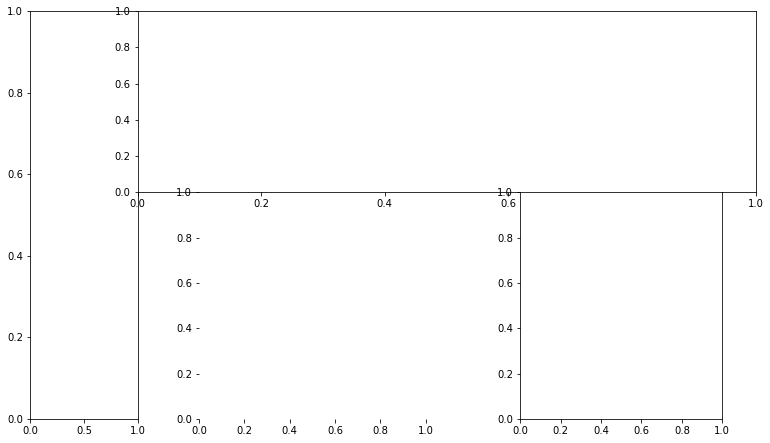

In [549]:
import matplotlib.colors as colors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 

        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.

        Returns
        ----------
        colour map'''


    def hex_to_rgb(value):
        '''
        Converts hex to rgb colours
        value: string of 6 characters representing a hex colour.
        Returns: list length 3 of RGB values'''
        value = value.strip("#") # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def rgb_to_dec(value):
        '''
        Converts rgb to decimal colours (i.e. divides each value by 256)
        value: list (length 3) of RGB values
        Returns: list (length 3) of decimal values'''
        return [v/256 for v in value]

    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

    
fig = plt.figure(figsize=(13, 7.5))
gs = fig.add_gridspec(2, 3, 
                      width_ratios=[0.4, 1.3, 1.0],
                      height_ratios=[0.8, 1], wspace=0.0, hspace=0.0)
ax_time = fig.add_subplot(gs[:, 0])
ax_text = fig.add_subplot(gs[0, 1:3])
ax_pie = fig.add_subplot(gs[1, 1])
ax_map = fig.add_subplot(gs[1, 2])

for year in range(1990, 2021):
# for year in range(2020, 2021):
    
    ################
    # Text summary #
    ################
    
    # Hide axis to create blank box
    ax_text.axis('off')
    
    # Add plot title and year
    ax_text.annotate('Coastal change in Australia'.upper(), 
                     xy=(0.03, 0.99), 
                     xycoords='axes fraction', 
                     va='top', 
                     fontsize=20, 
                     fontweight='bold')
    ax_text.annotate(year, 
                     xy=(0.97, 1.0), 
                     xycoords='axes fraction', 
                     ha='right', 
                     va='top', 
                     fontsize=65, 
                     fontweight='bold')
    
    # Calculate year-on-year change and set up symbols
    symbols = [u' \N{BLACK DOWN-POINTING TRIANGLE} down ', u' \N{BLACK UP-POINTING TRIANGLE} up ']
    absolute = pivot_df.loc[year]
    diffs = (pivot_df.loc[year] - pivot_df.loc[year - 1])
    triangles = pd.cut(diffs, [-100, 0, 100], labels=symbols)

    # Add retreat summary text
    retreat_text = (f"of Australia's non-rocky coastlines\nretreated by > 10 metres this year\n({triangles.iloc[0]}{diffs.abs().iloc[0]:.1f}% from {year - 1})")
    ax_text.annotate(f'{absolute.iloc[0]:.1f}%', (0.18, 0.76), xycoords='axes fraction', ha='right', va='top', fontsize=28, fontweight='bold')
    ax_text.annotate(retreat_text, (0.20, 0.77), xycoords='axes fraction', ha='left', va='top', fontsize=13)
    
    # Add grow summary text
    grow_text = (f"grew by > 10 metres this year\n({triangles.iloc[-1]}{diffs.abs().iloc[-1]:.1f}% from {year - 1})")
    ax_text.annotate(f'{absolute.iloc[-1]:.1f}%', (0.18, 0.41), xycoords='axes fraction', ha='right', va='top', fontsize=28, fontweight='bold')
    ax_text.annotate(grow_text, (0.20, 0.42), xycoords='axes fraction', ha='left', va='top', fontsize=13)
    
    # Add DEA logo overlay
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    from matplotlib.image import imread
    im_arr = imread('/g/data/r78/DEACoastlines/visualisation/images/dea_logo.png')
    imagebox = OffsetImage(im_arr, zoom=0.18)
    ab = AnnotationBbox(imagebox, 
                        xy=(0.68, 0.58), 
                        xycoords='axes fraction', 
                        box_alignment=(0, 1), 
                        frameon=False) 
    ax_text.add_artist(ab) 
    
    
    ##############
    # Timeseries #
    ##############

    # Cumulative plot of each year-on-year change
    pivot_df.loc[1989:year].plot.area(cmap='RdBu', 
                                      linewidth=0.6,
                                      ax=ax_time, legend=False)  
    for i, li in enumerate(ax_time.lines):
        li.set_color('black')        
        if i < 3:
            li.set_ydata(li.get_ydata() - 0.45)
    ax_time.axhline(50, c='black', linestyle='dashed')
    ax_time.set_xlim([1989, year])
    ax_time.set_ylim([0, 100])
    import matplotlib.ticker as mtick
    ax_time.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax_time.ticklabel_format(useOffset=False, axis='x', style='plain')
    ax_time.xaxis.set_major_formatter(mtick.FormatStrFormatter('%g'))
    ax_time.set_xlabel(None)
    
    # Add retreat and growth annotations
    ax_time.annotate('Growth', (0.50, 0.965), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    ax_time.annotate('Retreat', (0.50, 0.025), xycoords='axes fraction', ha='center', va='center', color='white', fontsize=12, fontweight='bold')
    
    
    ############
    # Pie plot #
    ############

    # Plot single year of data as a pie plot
    year_df = pivot_df.loc[year]
    year_df.plot.pie(cmap='RdBu', wedgeprops={"edgecolor":"black",'linewidth': 1.0, 'antialiased': True, "width": 0.5}, 
                     startangle=90, 
                     counterclock=True, 
                     fontsize=12,
                     autopct=lambda p:f'{p:.0f}%',
                     pctdistance=0.75, 
                     textprops={'fontsize': 14},
                     ax=ax_pie)
    
    # Add title and annotations
    ax_pie.annotate(year, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=15)
    ax_pie.annotate(("Results based on year-on-year change in the median annual position of the\n"
                     "shoreline mapped by Digital Earth Australia Coastlines; Bishop-Taylor et al.\n(2021). "
                     "Available at https://doi.org/10.1016/j.rse.2021.112734 (CC BY 4.0)"), 
                    (-0.10, 0.04), xycoords='axes fraction', ha='left', va='top', fontsize=7.8, color='grey')
    ax_pie.set_title(" ".join(f"Shoreline change in {year}".upper()), fontsize=11, pad=10)
    ax_pie.set_anchor('N')
    ax_pie.set_ylabel(None);   
    ax_pie.texts[1].set_color('white')
    ax_pie.texts[-3].set_color('white')
    
    
    ############
    # Plot map #
    ############    

    # Select average rate of change for year and join to coastal regions data
    region_df = region_rate_df.xs(year, level='year').round(1)
    acsc_regions_results = acsc_regions.join(region_df)
    
    # Create a custom inset for legend
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax_map,
                 width=1.1,  
                 height=0.2,
                 bbox_to_anchor=[0.72, 0.12],
                 bbox_transform=plt.gcf().transFigure,
                 loc='center'
                   )
    
    # Plot coastal regions data     
    cmap = get_continuous_cmap(hex_list=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7',
                                         '#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'], 
                               float_list=[0, 0.10, 0.30, 0.40, 0.45, 0.5, 0.55, 0.60, 0.70, 0.90, 1.0])

    acsc_regions_results.plot(column='distance', 
                              cmap=cmap,
                              vmin=-5, 
                              vmax=5, 
                              ax=ax_map, 
                              edgecolor='black', 
                              linewidth=1,
                              legend=True,
                              cax=cax,
                              legend_kwds={'label': None, 
                                           'orientation': "horizontal",
                                           'ticks': []})
    cax.set_title('Median shoreline change', pad=9, y=-20)
    cax.get_yaxis().set_ticks([])
    for loc, lab in zip([-7.1, 0, 7.1], ['-5 m', '0 m', '+5 m']):
        cax.text(loc, -0.8, lab, ha='center', va='center', color='black')
    
    ax_map.annotate(f"{acsc_regions_results.loc['South-eastern Coasts'].distance:.1f} m", 
                    xy=(150.5, -36), 
                    xytext=(154, -42), 
                    arrowprops=dict(arrowstyle='-', lw=0.6),
                    fontsize=12,
                    va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['North-eastern Coasts'].distance:.1f} m", 
                xy=(145.49898, -17.10035), 
                xytext=(153, -14), 
                arrowprops=dict(arrowstyle='-', lw=0.6),
                fontsize=12,
                va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Carpentaria Gulf Coasts'].distance:.1f} m        ", 
            xy=(139, -17), 
            xytext=(139, -8.5), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['North-western Coasts'].distance:.1f} m", 
            xy=(122.82193, -16.79609), 
            xytext=(119.5, -13), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Western Coasts'].distance:.1f} m", 
            xy=(115.2, -30), 
            xytext=(111.8, -30), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='right')
    
    ax_map.annotate(f"{acsc_regions_results.loc['Southern Coasts'].distance:.1f} m", 
            xy=(128.5, -32), 
            xytext=(128.5, -37), 
            arrowprops=dict(arrowstyle='-', lw=0.6),
            fontsize=12,
            va='center', ha='center')
    
    # Add annotions and title
    ax_map.annotate('Australia', (0.48, 0.55), xycoords='axes fraction', ha='center', va='center', fontsize=15)
    ax_map.set_title(" ".join("Change by coastal region".upper()), fontsize=11, pad=10)
    ax_map.set_anchor('N')
    ax_map.axis('off');
    
    
    ################
    # Export image #
    ################
    
    fig.savefig(f'deacoastlines_annualupdate_{year}.png', bbox_inches='tight', pad_inches=0.1, dpi=111.5)
    
    ax_text.cla()
    ax_map.cla()
    ax_pie.cla()
    ax_time.cla()
    fig.delaxes(cax)


In [550]:
!ffmpeg -y -r 6 -start_number 1990 -i deacoastlines_annualupdate_%4d.png -c:v libx264 -vf "fps=6,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" temp.mp4
!ffmpeg -y -i temp.mp4 -filter_complex "[0]trim=0:5[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy temp2.mp4
!ffmpeg -y -i temp2.mp4 -filter_complex "[0]trim=0:5[hold],[0][hold]concat[extended],[extended][0]overlay" -pix_fmt yuv420p -c:a copy deacoastlines_annualupdate_{year}.mp4

ffmpeg version 3.3.4-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-4) 20170820
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libfribidi --enable-libass --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6.

In [15]:
# !ffmpeg -y -r 10 -start_number 1 -i animation_%1d.png -c:v libx264 -vf "fps=10,format=yuv420p,pad=ceil(iw/2)*2:ceil(ih/2)*2" temp.mp4


!ffmpeg -y -loop 1 -r 6 -i animation_%1d.png -t 12 -vf "fps=6,format=yuv420p" output.mp4

ffmpeg version 3.3.4-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-4) 20170820
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libfribidi --enable-libass --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6.

In [317]:
str(ax_time.get_xticklabels())

'<a list of 3 Text major ticklabel objects>'

In [147]:
acsc_regions_results.representative_point()

Descriptio
Carpentaria Gulf Coasts    POINT (136.43167 -14.30879)
North-eastern Coasts       POINT (145.49898 -17.10035)
North-western Coasts       POINT (122.82193 -16.79609)
South-eastern Coasts       POINT (151.91057 -33.85863)
Southern Coasts            POINT (119.57562 -34.54505)
Western Coasts             POINT (114.20237 -27.78381)
dtype: geometry

In [119]:
"\n" + " ".join(f"Shoreline change in {year}".upper()) + "\n"

'\nS H O R E L I N E   C H A N G E   I N   2 0 2 0\n'

In [ ]:
pivot_df


# year = 2020

symbols = [u' \N{BLACK DOWN-POINTING TRIANGLE} ', u' \N{BLACK UP-POINTING TRIANGLE} ']
absolute = pivot_df.loc[year]
diffs = (pivot_df.loc[year] - pivot_df.loc[year - 1])
triangles = pd.cut(diffs, [-100, 0, 100], labels=symbols)

# print(f'Erosion (> 10m):  {absolute.iloc[0]:.1f}% ( {triangles.iloc[0]} {diffs.iloc[0]:.1f}%)\n Growth (> 10m):  {absolute.iloc[-1]:.1f}% ( {triangles.iloc[-1]} {diffs.iloc[-1]:.1f}%)')
# # print(f'{absolute.iloc[-1]:.1f}% ( {triangles.iloc[-1]} {diffs.iloc[-1]:.1f}%) grew')

print(f"In {year}, {absolute.iloc[0]:.1f}% of Australia's coastline retreated by more than 10 metres ({triangles.iloc[0]} {diffs.iloc[0]:.1f}% since {year - 1}), while "
      f"{absolute.iloc[-1]:.1f}% grew ({triangles.iloc[-1]}{diffs.iloc[-1]:.1f}% since {year - 1})")

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:
region_df = prop_region_df.xs(year, level='year').reset_index().pivot(index='region', columns='class', values='distance')
# region_df = diff_long.groupby(['region', 'year'])[['distance']].mean().xs(year, level='year')
acsc_regions_results = acsc_regions.join(region_df)

acsc_regions_results['eroded'] = acsc_regions_results.iloc[:, 1:4].sum(axis=1)   #
acsc_regions_results['grown'] = acsc_regions_results.iloc[:, 4:7].sum(axis=1)
acsc_regions_results['diff'] = (acsc_regions_results['grown'] - acsc_regions_results['eroded'])

acsc_regions_results.plot(column='diff', cmap='RdBu', vmin=-30, vmax=30, ax=ax_map, edgecolor='black')

In [ ]:
year = 2020
year_df = pivot_df.loc[year]
year_df.plot.pie(cmap='RdBu', wedgeprops={"edgecolor":"black",'linewidth': 0.6, 'antialiased': True, "width": 0.5}, startangle=90, counterclock=True, autopct=lambda p:f'{p:.0f}%',
                        pctdistance=0.75,)
plt.ylabel(None);

In [ ]:
wedges, texts = plt.pie(year_df.values, 
                        wedgeprops={"edgecolor":"black",'linewidth': 0.6, 'antialiased': True, "width": 0.5}, 
                        startangle=90, 
                        counterclock=True, 
                        autopct=lambda p:f'{p:.0f}%',
                        pctdistance=0.75,
                       )

In [ ]:
plt.pie

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# year = 2020
# diffs = (test2.loc[year] - test2.loc[year - 1])
# diffs.plot.bar(width=0.9, color=plt.cm.RdBu(np.linspace(0, 1, 6)))

# rates = diffs.index.values
# symbols = [u'\N{BLACK DOWN-POINTING TRIANGLE}', u'\N{box drawings heavy horizontal}', u'\N{BLACK UP-POINTING TRIANGLE}']
# triangles = pd.cut(diffs, [-100, -0.5, 0.5, 100], labels=symbols)
# percents = [f'{abs(diff):.1f}%' for diff in diffs]
# labels = [f'{r}\n\n{t} {p}' for r, t, p in zip(rates, triangles, percents)]

# ax.set_frame_on(False)
# ax.yaxis.set_visible(False)
# ax.xaxis.set_tick_params(length=0)
# ax.set(xlabel="")

# ax.xaxis.set_ticks_position('top')
# ax.set_xticklabels(labels, rotation = 0, fontsize=15);

In [ ]:
# diffs = (test2.loc[year] - test2.loc[year - 1])
# diffs

In [ ]:
# year = 2019
# test2.loc[year]

In [ ]:
pivot_df

In [ ]:
year = 2020

symbols = [u' \N{BLACK DOWN-POINTING TRIANGLE} ', u' \N{BLACK UP-POINTING TRIANGLE} ']
absolute = pivot_df.loc[year]
diffs = (pivot_df.loc[year] - test2.loc[year - 1])
triangles = pd.cut(diffs, [-100, 0, 100], labels=symbols)

# print(f'Erosion (> 10m):  {absolute.iloc[0]:.1f}% ( {triangles.iloc[0]} {diffs.iloc[0]:.1f}%)\n Growth (> 10m):  {absolute.iloc[-1]:.1f}% ( {triangles.iloc[-1]} {diffs.iloc[-1]:.1f}%)')
# print(f'{absolute.iloc[-1]:.1f}% ( {triangles.iloc[-1]} {diffs.iloc[-1]:.1f}%) grew')

print(f"In {year}, {absolute.iloc[0]:.1f}% of Australia's coastline retreated by > 10 metres ({triangles.iloc[0]} {diffs.iloc[0]:.1f}% since {year - 1}), while "
      f"{absolute.iloc[-1]:.1f}% grew ({triangles.iloc[-1]}{diffs.iloc[-1]:.1f}% since {year - 1})")

In [ ]:
years = range(1988,2021)
thresh = 10

retreat_rates = []
growth_rates = []

for year in years:

    
    retreat_perc = (diff_gdf[f"dist_{year}"] <= -thresh).mean().item()
    growth_perc = (diff_gdf[f"dist_{year}"] >= thresh).mean().item()
    retreat_rates.append(retreat_perc)
    growth_rates.append(growth_perc)
    
#     print(f'{year} growth greater than {str(thresh)} m / year: {retreat_perc:.2%}')
#     print(f'    retreat greater than {str(thresh)} m / year: {growth_perc:.2%}')

In [ ]:
test = pd.DataFrame(data={'growth': growth_rates, 'retreat': retreat_rates}, index=years)  #.drop([1991, 1992, 1993, 1994])
# test.plot(figsize=(15, 5))

In [ ]:
fig, ax = plt.subplots()
ax.stackplot(test.index, [test.growth, test.retreat], baseline='sym')
plt.axhline(0, c='black', linestyle='dashed')

In [ ]:
test.plot.area(figsize=(10, 5))
plt.axhline(0.5, c='black', linestyle='dashed')
# plt.xlim([1989,2020])
plt.ylim([0, 1.0])

In [ ]:
test.retreat.mean()

In [ ]:
test.growth.mean()

In [ ]:
soi = pd.read_csv('input_data/climate_indices.csv', index_col='year')
soi

In [ ]:
soi_test = test.join(soi.shift(0))
soi_test['diff'] = soi_test.retreat - soi_test.growth

soi_test.plot.scatter(x='SOI', y='diff')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** July 2021